In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
#load data emissions data from 1990-2050 with Virginia and West Virginia removed
df = pd.read_csv('cleaned_co2_data_non_va_wv.csv')

In [3]:
#Find the top 10 counties in U.S. by emissions in 2005 from the dataset
top_10_2005 = df[df['year'] == 2005].nlargest(10, 'emissions')[['geoid', 'emissions']]
print(top_10_2005)

       geoid     emissions
2174    6037  4.594753e+07
30878  48201  2.333651e+07
1262    4013  2.013627e+07
7034   17031  1.675775e+07
2390    6073  1.592305e+07
2306    6059  1.474732e+07
30350  48113  1.393518e+07
2378    6071  1.258334e+07
2342    6065  1.155776e+07
4058   12086  1.043692e+07


In [4]:
#Find the top 10 counties by emissions in New York State for 2005(FIPS code starts with 36)
ny_2005_emissions = df[(df['year'] == 2005) & (df['geoid'].astype(str).str.startswith('36'))]
top_10_ny = ny_2005_emissions[ny_2005_emissions['year'] == 2005].nlargest(10,'emissions')[['geoid', 'emissions']]
print(top_10_ny)

       geoid  emissions
22106  36103  6706605.2
21842  36059  4900160.7
22202  36119  3960537.0
21662  36029  3939799.1
21974  36081  3511691.6
21818  36055  3125702.7
21770  36047  2359887.4
21914  36071  2242976.1
21890  36067  2170325.8
21854  36061  1757689.0


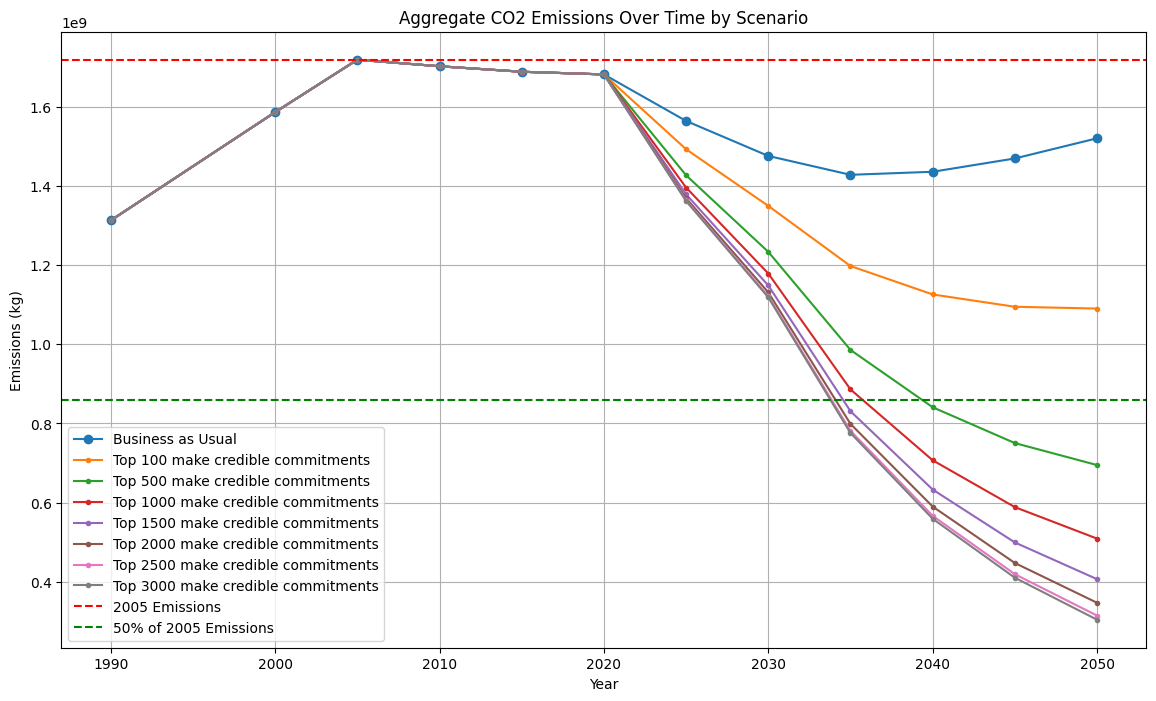

In [3]:
#Plot emissions trends assuming that emissions reductions begin starting in 2020
co2_data_full = df.copy()

top_counts = [100, 500, 1000, 1500, 2000, 2500, 3000]
top_counties = {count: co2_data_full[co2_data_full['year'] == 2005].nlargest(count, 'emissions')['geoid'].unique()
                for count in top_counts}

#Identify the top 100, 200, ..., 1000 counties in 2005
top_counts = [100, 500, 1000, 1500, 2000, 2500, 3000]
top_counties = {count: co2_data_full[co2_data_full['year'] == 2005].nlargest(count, 'emissions')['geoid'].unique()
                for count in top_counts}

#Prepare data for reduction from 2020 onwards
years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
reductions = {2025: 0.1294, 2030: 0.1294, 2035: 0.2831, 2040: 0.2831, 2045: 0.2831, 2050: 0.2831}

#Function to apply reduction
def apply_scenario_reduction(data, top_counties, reduction_years):
    data = data.copy()
    for year in reduction_years:
        if year > 2020:
            previous_year = year - 5
            rate = 1 - reductions[year]
            data.loc[(data['geoid'].isin(top_counties)) & (data['year'] == year), 'emissions'] *= rate
            # Apply recursively for following years
            for future_year in range(year+5, 2051, 5):
                data.loc[(data['geoid'].isin(top_counties)) & (data['year'] == future_year), 'emissions'] *= rate
    return data

#Apply the scenario reductions
scenario_data = {}
for count in top_counts:
    scenario_data[count] = apply_scenario_reduction(co2_data_full, top_counties[count], years)

#Calculate aggregate emissions by year for each scenario
scenario_aggregates = {count: scenario_data[count].groupby('year')['emissions'].sum() for count in top_counts}

# Also calculate the business as usual case (no reduction)
ba_aggregate = co2_data_full.groupby('year')['emissions'].sum()

#Calculate benchmark aggregate emissions for 2005 and 50% of that
emissions_2005 = co2_data_full[co2_data_full['year'] == 2005]['emissions'].sum()
half_emissions_2005 = 0.5 * emissions_2005

#Plot with benchmarks
plt.figure(figsize=(14, 8))
plt.plot(ba_aggregate.index, ba_aggregate, label='Business as Usual', marker='o', linestyle='-')

for count in top_counts:
    plt.plot(scenario_aggregates[count].index, scenario_aggregates[count], label=f'Top {count} make credible commitments', marker='.')

#Adding horizontal lines
plt.axhline(y=emissions_2005, color='r', linestyle='--', label='2005 Emissions')
plt.axhline(y=half_emissions_2005, color='g', linestyle='--', label='50% of 2005 Emissions')

plt.title('Aggregate CO2 Emissions Over Time by Scenario')
plt.xlabel('Year')
plt.ylabel('Emissions (kg)')
plt.legend()
plt.grid(True)
plt.show()

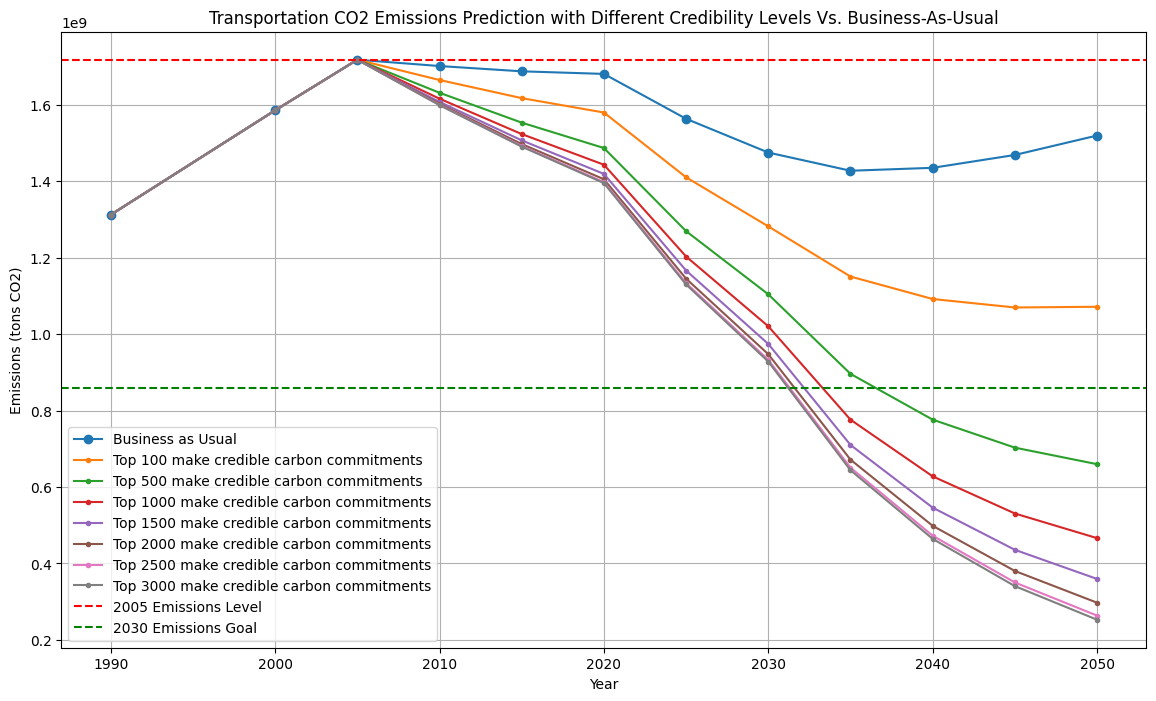

In [4]:
#Plot emissions trends assuming that emissions reductions begin in 2005
co2_data_full = df.copy()
#Set list of years by which reductions are to be achieved
years_2005 = [2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050]
#Set emissions reduction percent in each year
reductions_2005 = {2005: .0602, 2010: .0602, 2015: .0602, 2020: .0602, 2025: 0.1294, 2030: 0.1294, 2035: 0.2831, 2040: 0.2831, 2045: 0.2831, 2050: 0.2831}

#Function to implement scenario
def apply_scenario_reduction_2005(data, top_counties, reduction_years):
    data = data.copy()
    for year in reduction_years:
        if year > 2005:
            previous_year = year - 5
            rate = 1 - reductions_2005[year]
            data.loc[(data['geoid'].isin(top_counties)) & (data['year'] == year), 'emissions'] *= rate
            for future_year in range(year+5, 2051, 5):
                data.loc[(data['geoid'].isin(top_counties)) & (data['year'] == future_year), 'emissions'] *= rate
    return data

#Implement the scenario
scenario_2005_data = {}
for count in top_counts:
    scenario_2005_data[count] = apply_scenario_reduction_2005(co2_data_full, top_counties[count], years_2005)

#Calculate aggregate emissions by year for each scenario
scenario_2005_aggregates = {count: scenario_2005_data[count].groupby('year')['emissions'].sum() for count in top_counts}

#Calculate the business as usual case (no reduction)
ba_aggregate = co2_data_full.groupby('year')['emissions'].sum()

#Calculate the aggregate emissions for 2005 and 50% of that to use as benchmarks
emissions_2005 = co2_data_full[co2_data_full['year'] == 2005]['emissions'].sum()
half_emissions_2005 = 0.5 * emissions_2005

#Generate figure and labels
plt.figure(figsize=(14, 8))
plt.plot(ba_aggregate.index, ba_aggregate, label='Business as Usual', marker='o', linestyle='-')

for count in top_counts:
    plt.plot(scenario_2005_aggregates[count].index, scenario_2005_aggregates[count], label=f'Top {count} make credible carbon commitments', marker='.')
plt.axhline(y=emissions_2005, color='r', linestyle='--', label='2005 Emissions Level')
plt.axhline(y=half_emissions_2005, color='g', linestyle='--', label='2030 Emissions Goal')

plt.title('Transportation CO2 Emissions Prediction with Different Credibility Levels Vs. Business-As-Usual')
plt.xlabel('Year')
plt.ylabel('Emissions (tons CO2)')
plt.legend()
plt.grid(True)
plt.show()

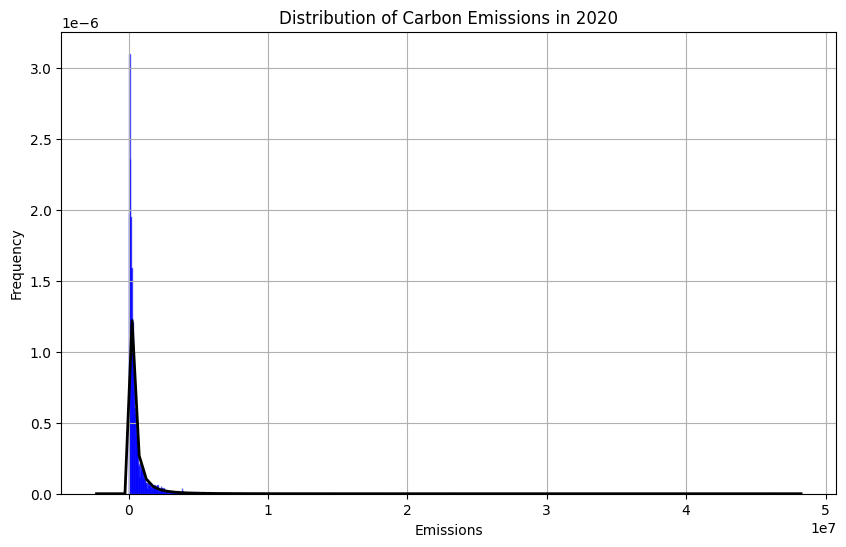

In [11]:
from scipy.stats import lognorm

#fit log-normal distribution to the emissions data for 2005
shape, loc, scale = lognorm.fit(emissions_2020)

#plot histogram with fitted pdf
plt.figure(figsize=(10, 6))
plt.hist(emissions_2005, bins=1000, density=True, color='blue', edgecolor='blue', alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
title = f"Distribution of Carbon Emissions in 2020"
plt.title(title)
plt.xlabel('Emissions')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()